<a href="https://colab.research.google.com/github/Ajay-user/ML-DL-RL-repo/blob/master/seq2seq/Transformer_model_Portuguese_to_English.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_datasets
!pip install -U 'tensorflow-text==2.8.*'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 30.3 MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow_datasets as tfds
import tensorflow as tf

# Import tf_text to load the ops used by the tokenizer saved model
import tensorflow_text as tf_text


## Download the Dataset

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteNAY32E/ted_hrlr_translate-train.tfrecord


  0%|          | 0/51785 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteNAY32E/ted_hrlr_translate-validation.tfrecord


  0%|          | 0/1193 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteNAY32E/ted_hrlr_translate-test.tfrecord


  0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [4]:
for pt, en in train_examples.batch(1).take(1):
  print('Portuguese : ', pt.numpy())
  print('Englist : ', en.numpy())

Portuguese :  [b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .']
Englist :  [b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .']


### Text tokenization & detokenization

In [5]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

196608/184801 [===============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [6]:
tokenizer = tf.saved_model.load(model_name)

In [7]:
# tokenizer
print('output of tokenizer is a Ragged tensor \n',tokenizer.pt.tokenize(pt))
print('look up of tokens \n',tokenizer.pt.lookup( tokenizer.pt.tokenize(pt) ))
print('output of detokenize method is a tensor\n', tokenizer.pt.detokenize( tokenizer.pt.tokenize(pt) ))

output of tokenizer is a Ragged tensor 
 <tf.RaggedTensor [[2, 44, 115, 6402, 148, 40, 887, 14, 3936, 40, 463, 2715, 94, 2047, 14,
  84, 44, 40, 117, 1328, 2721, 818, 539, 16, 3]]>
look up of tokens 
 <tf.RaggedTensor [[b'[START]', b'e', b'quando', b'melhora', b'##mos', b'a', b'procura',
  b',', b'tiramos', b'a', b'unica', b'vantagem', b'da', b'impressao',
  b',', b'que', b'e', b'a', b'ser', b'##en', b'##di', b'##p', b'##idade',
  b'.', b'[END]']]>
output of detokenize method is a tensor
 tf.Tensor([b'e quando melhoramos a procura , tiramos a unica vantagem da impressao , que e a serendipidade .'], shape=(1,), dtype=string)


### investigate the distribution of tokens per example in the dataset

In [8]:
length = []
for pt, en in train_examples.batch(1024):
  pt_toks = tokenizer.pt.tokenize(pt)
  length.append(pt_toks.row_lengths())
  en_toks = tokenizer.en.tokenize(en)
  length.append(en_toks.row_lengths())


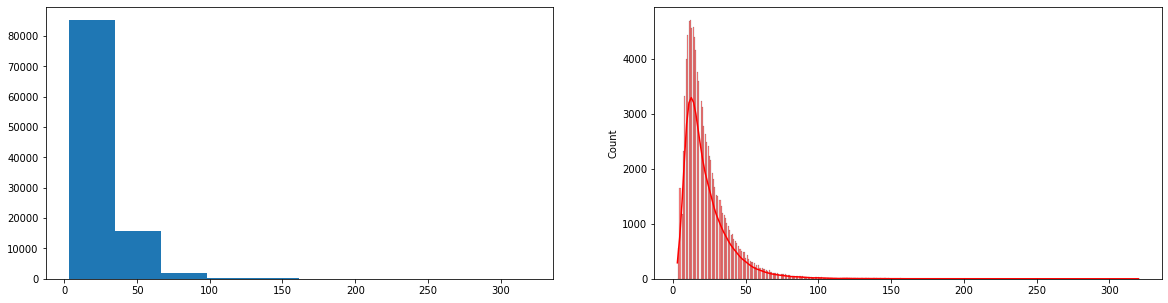

In [9]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(np.concatenate(length));
plt.subplot(122)
sns.histplot(np.concatenate(length), kde=True, color='red');
plt.subplots_adjust(hspace=0.8)

In [10]:
MAX_TOKENS = 128
BUFFER_SIZE = 20000
BATCH_SIZE = 64

## Setup input pipeline


* Define a function to drop the examples longer than MAX_TOKENS:
* Define a function that tokenizes the batches of raw text:
* processes, shuffles and batches the data

In [11]:
def max_token_filter(pt,en):
  maxi = tf.maximum(tf.shape(pt)[1], tf.shape(en)[1])
  return maxi<MAX_TOKENS

In [12]:
def tokenzie_pair(pt,en):
  pt = tokenizer.pt.tokenize(pt)
  pt = pt.to_tensor()# Convert from ragged to dense, padding with zeros.
  en = tokenizer.en.tokenize(en)
  en = en.to_tensor()# Convert from ragged to dense, padding with zeros.
  return pt,en

In [13]:
def prepare_ds(ds):
  ds = ds.cache()
  ds = ds.shuffle(BATCH_SIZE)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.map(tokenzie_pair, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.filter(max_token_filter)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [14]:
train_batches = prepare_ds(train_examples)
val_batches = prepare_ds(val_examples)

## Positional encoding
In languages the order of the words and their position in a sentence really matters. The meaning of the entire sentence can change if the words are re-ordered. When implementing NLP solutions, the recurrent neural networks have an inbuilt mechanism that deals with the order of sequences. The transformer model, however, does not use recurrence or convolution and treats each data point as independent of the other. Hence, positional information is added to the model explicitly to retain the information regarding the order of words in a sentence. Positional encoding is the scheme through which the knowledge of order of objects in a sequence is maintained.

Embedding layer will create word vectors such that words that have similar meaning will be together and words that are different will be far apart in the n-dimensional space.

Attension mechanism will add contextual information to the word vectors 

Now we have both meaning and context but lacks positional information

Attention layers see their input as a set of vectors, with no sequential order. This model also doesn't contain any recurrent or convolutional layers. Because of this a "positional encoding" is added to give the model some information about the relative position of the tokens in the sentence.

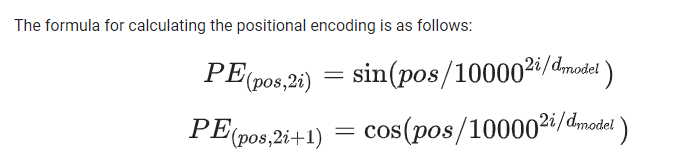

In [15]:
def get_angles(pos, i, d):
  frac = 1 / np.power(10000, (2* (i//2))/d)
  return pos*frac

In [16]:
def positional_embedding(positions, dim):
  '''
  positions --> number of words in a batch # MAXTOKENS
  dim --> dimesionality of the word vector
  '''
  pos = np.arange(positions)[:,np.newaxis]
  i = np.arange(dim)[np.newaxis,:]
  angles = get_angles(pos,i,dim)

  angles[:,0::2] = np.sin(angles[:,0::2])
  angles[:,1::2] = np.cos(angles[:,1::2])

  # pe is added to embeddings which has a shape [batch, seq, dim ]
  return tf.cast(angles[np.newaxis, :], dtype=tf.float32)

In [17]:
# lets check the positional embeddings
pe = positional_embedding(128, 512)
pe.shape

TensorShape([1, 128, 512])

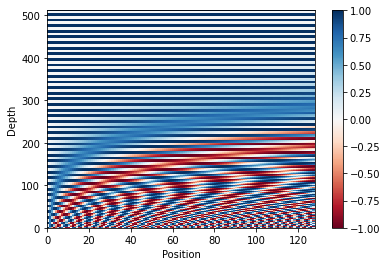

In [18]:
# Juggle the dimensions for the plot
pe_ = tf.transpose(pe[0])
plt.pcolormesh(pe_, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Masking
**Padding mask**<br>
Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

**Look-ahead mask**<br>
The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third token, only the first and second token will be used. Similarly to predict the fourth token, only the first, second and the third tokens will be used and so on.



The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [19]:
def padding_mask(seq):
  '''input spanish tokens ==> output spanish mask
  '''
  mask = tf.cast(tf.equal(seq,0), dtype=tf.float32)
  # to broadcast over the attentions output  we've to reshape this mask
  # attention output = [batch, head, query, key]
  mask = mask[:, tf.newaxis, tf.newaxis, :]
  return mask

def lookahead_mask(size):
  input = tf.ones([size,size])
  lt = tf.linalg.band_part(input, -1, 0)
  return 1-lt


In [20]:
(sample_pt_batch, sample_en_batch) = next(iter(train_batches))

In [21]:
# lets see some tokens
for en in sample_en_batch[:5]:
  print(en)

tf.Tensor(
[   2   72   71 2124   83    9  105   77   94  300   15    3    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(46,), dtype=int64)
tf.Tensor(
[   2  285   76    9   55  139   78  141   37 1252 3896   75  196   50
    9   56  112 1708   90    9   55 1557 6111   13   71 4259   77  183
   13   87  150 5646   90   78  190  634   13   71  167   75   86 5731
   15    3    0    0], shape=(46,), dtype=int64)
tf.Tensor(
[   2   87   83  149   50    9   56  664   85 2512   15    3    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(46,), dtype=int64)
tf.Tensor(
[   2   72   71  740  258   71 1581   13   77  180  395   13   71  241
   76   80   15    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   

In [22]:
print('Shape of pt tokens',sample_pt_batch.shape)
print('Shape of en tokens',sample_en_batch.shape)

Shape of pt tokens (64, 55)
Shape of en tokens (64, 46)


In [23]:
sample_pt_mask = padding_mask(sample_pt_batch)
print('Shape of pt tokens',sample_pt_batch.shape,' Shape of pt mask',sample_pt_mask.shape)

Shape of pt tokens (64, 55)  Shape of pt mask (64, 1, 1, 55)


In [24]:
sample_en_mask = padding_mask(sample_en_batch)
print('Shape of en tokens',sample_en_batch.shape,' Shape of en mask',sample_en_mask.shape)

Shape of en tokens (64, 46)  Shape of en mask (64, 1, 1, 46)


In [25]:
lookahead = lookahead_mask(sample_en_batch.shape[1])
lookahead

<tf.Tensor: shape=(46, 46), dtype=float32, numpy=
array([[0., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [26]:
# we apply this lookahead+padding mask in decoder
# the attention output shape is [batch, head, query, key]
lookahead_and_padding = tf.maximum(sample_en_mask, lookahead)
print('Shape of lookahead + padding mask', lookahead_and_padding.shape)

Shape of lookahead + padding mask (64, 1, 46, 46)


## Scaled dot product attention

formula : softmax( Q.k<sup>t</sup> / sqrt(d) ) . V


The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax.

For example, consider that Q and K have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of dk. So the square root of dk is used for scaling, so you get a consistent variance regardless of the value of dk. 

In [27]:
def scaled_dot_product_attention(q,k,v,mask=None):
  # dot product [b, q, d] . [b, k, d]T => [b, q, k]
  dot_prod = tf.matmul(q,k,transpose_b=True)

  # scale by sqrt(dim)
  dk = tf.cast(tf.shape(k)[-1], dtype=tf.float32)
  dot_prod /= tf.math.sqrt(dk)


  # apply mask
  if mask is not None:
    dot_prod+=(mask * -1e9)


  # relative similarity score -- softmax
  weights = tf.nn.softmax(dot_prod, axis=-1)

  # attention [b, q, k] . [b, v, d] => [b, q, d]
  attention = tf.matmul(weights, v)
  return attention, weights

In [28]:
# lets check this
pt_vocab_size = tokenizer.pt.get_vocab_size().numpy()
en_vocab_size = tokenizer.en.get_vocab_size().numpy()

pt_embed = tf.keras.layers.Embedding(pt_vocab_size, 512)
en_embed = tf.keras.layers.Embedding(en_vocab_size, 512)

pt_embeddings = pt_embed(sample_pt_batch)
en_embeddings = en_embed(sample_en_batch)

print('shape of pt embeddings',pt_embeddings.shape)
print('shape of en embeddings',en_embeddings.shape)

print('sample pt mask', sample_pt_mask.shape)
print('attention')

attention_output,_ = scaled_dot_product_attention(pt_embeddings,pt_embeddings,pt_embeddings,None)
print(attention_output.shape)

shape of pt embeddings (64, 55, 512)
shape of en embeddings (64, 46, 512)
sample pt mask (64, 1, 1, 55)
attention
(64, 55, 512)


In [29]:
# example 2

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)

attention_output, weights = scaled_dot_product_attention(temp_q,temp_k,temp_v,None)
attention_output, weights 

(<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[5.500000e+02, 5.500000e+00],
        [1.000000e+01, 9.276602e-25],
        [5.500000e+00, 4.638301e-25]], dtype=float32)>,
 <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
 array([[4.216637e-26, 4.216637e-26, 5.000000e-01, 5.000000e-01],
        [8.433274e-26, 1.000000e+00, 8.433274e-26, 8.433274e-26],
        [5.000000e-01, 5.000000e-01, 4.216637e-26, 4.216637e-26]],
       dtype=float32)>)

## Multi head Attention

Multi-head attention consists of four parts:

Linear layers.
Scaled dot-product attention.
Final linear layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information from different representation subspaces at different positions. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

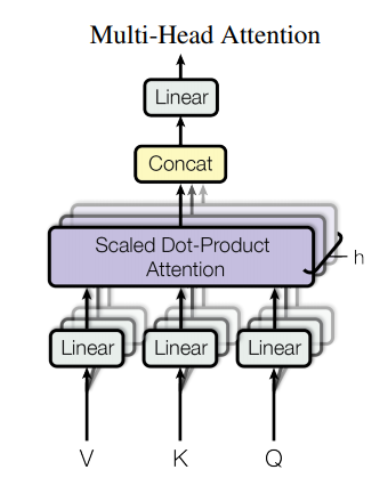

In [30]:
class Multi_Head_Attention(tf.keras.layers.Layer):
  def __init__(self, num_heads, dims):
    super(Multi_Head_Attention, self).__init__()

    self.dims=dims
    self.num_heads = num_heads
    self.depth = dims//num_heads

    tf.assert_equal(dims%num_heads,0)

    self.dq = tf.keras.layers.Dense(dims)
    self.dk = tf.keras.layers.Dense(dims)
    self.dv = tf.keras.layers.Dense(dims)

    self.dense =  tf.keras.layers.Dense(dims)

  def split_heads(self, vector):
    # [b s dim] ==> [b s head dept]
    vector = tf.reshape(vector, shape=[self.batch_size, -1, self.num_heads, self.depth])
    # traspose [b s head dept] ==> [b, head, s, depth]
    vector = tf.transpose(vector, [0,2,1,3])
    return vector

  def concat_heads(self, vector):
    # [b, head, s, depth] ==> [b, s, head, depth]
    vector = tf.transpose(vector,[0,2,1,3])
    vector = tf.reshape(vector, shape=[self.batch_size, -1, self.dims])
    return vector
  
  def call(self, q, k, v, mask):

    # calculate the batch size
    self.batch_size = tf.shape(q)[0]

    # [b, s, emb_dim] ==> [b, s, dims]
    q = self.dq(q)
    k = self.dk(k)
    v = self.dv(v)
    # split for multi heads [b, s, dims] = [b, head, s, depth]
    q = self.split_heads(q)
    k = self.split_heads(k)
    v = self.split_heads(v)

    # attention
    attention, weights = scaled_dot_product_attention(q, k, v, mask)

    # concat the heads
    attention = self.concat_heads(attention)

    # dense layer
    dense_out = self.dense(attention)

    return dense_out, weights




In [31]:
# example
mha = Multi_Head_Attention(num_heads=8, dims=512)
# (batch_size, encoder_sequence, emd_dims)
y = pt_embeddings
out,weights = mha(y,y,y,None)
print('Input shape of q,k,v', y.shape)
print('output of mha shape',out.shape)
print('shape of attention weights',weights.shape)

Input shape of q,k,v (64, 55, 512)
output of mha shape (64, 55, 512)
shape of attention weights (64, 8, 55, 55)


## Point wise feed forward network
Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between

In [32]:
def FFNN(units, dim):
  return tf.keras.Sequential([
            tf.keras.layers.Dense(units,'relu'),
            tf.keras.layers.Dense(dim)
  ])

In [33]:
# example
ffnn = FFNN(2048,512)
out = ffnn(out)
print(out.shape)

(64, 55, 512)




The input sentence is passed through N encoder layers that generates an output for each token in the sequence.
The decoder attends to the encoder's output and its own input (self-attention) to predict the next word.

## Encoder Layer


In [34]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, dims, dense_units, num_heads, dropout_rate=0.1):
    super(EncoderLayer, self).__init__()

    self.add_and_norm_1 = tf.keras.layers.LayerNormalization()
    self.add_and_norm_2 = tf.keras.layers.LayerNormalization()

    self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)
    self.dropout_2 = tf.keras.layers.Dropout(dropout_rate)

    self.ffnn = FFNN(dense_units, dims)
    self.mha = Multi_Head_Attention(num_heads, dims)
  
  def call(self, x, mask, training):

    # multi-head attention
    attention_vector, weights = self.mha(x,x,x,mask)
    # dropout
    vector = self.dropout_1(attention_vector, training=training)
    # add and normalize
    out1 = self.add_and_norm_1(vector+x)

    # FFNN
    ffnn_out = self.ffnn(out1)
    # dropout
    vector = self.dropout_2(ffnn_out, training=training)
    # add and normalize
    out2 = self.add_and_norm_2(vector + out1)

    return out2


In [35]:
# example check
enc_layer = EncoderLayer(dims=512, dense_units=2048, num_heads=8)

seq_len = tf.shape(pt_embeddings)[1]
inp = pt_embeddings + pe[:,:seq_len,:]

enc_out = enc_layer(inp, mask=sample_pt_mask, training=True)

print('shape of mask :',sample_pt_mask.shape)
print('shape of input :',inp.shape)
print('shape of output :',enc_out.shape)

shape of mask : (64, 1, 1, 55)
shape of input : (64, 55, 512)
shape of output : (64, 55, 512)


In [36]:
# this encoder layer is repeatead many times { n = 6 }
x = pt_embeddings + pe[:, :seq_len, :]
for i in range(6):
  x = enc_layer(x, mask=sample_pt_mask, training=True)

print('shape of mask :',sample_pt_mask.shape)
print('shape of input [portuguese embedding + pe]:',inp.shape)
print('shape of output :',enc_out.shape)

shape of mask : (64, 1, 1, 55)
shape of input [portuguese embedding + pe]: (64, 55, 512)
shape of output : (64, 55, 512)


## Decoder Layer

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next token by looking at the encoder output and self-attending to its own output

In [37]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, dims, dense_units, num_heads, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.add_and_norm_1 = tf.keras.layers.LayerNormalization()
    self.add_and_norm_2 = tf.keras.layers.LayerNormalization()
    self.add_and_norm_3 = tf.keras.layers.LayerNormalization()

    self.drop_out_1 = tf.keras.layers.Dense(dims)
    self.drop_out_2 = tf.keras.layers.Dense(dims)
    self.drop_out_3 = tf.keras.layers.Dense(dims)

    self.mha = Multi_Head_Attention(num_heads, dims)
    self.ffnn = FFNN(dense_units, dims)

  def call(self, inputs, encoder_inputs, mask, training):

    # masked multi head attention
    attention_vector, attention_weights = self.mha(inputs, inputs, inputs, mask['lookahead'])
    # dropout
    d1 = self.drop_out_1(attention_vector, training=training)
    # add and normalize
    n1 =  self.add_and_norm_1( d1 + inputs )

    # cross attention
    cross_attention_vector, cross_attention_weights = self.mha(q=n1, k=encoder_inputs, v=encoder_inputs, mask=mask['padding'])
    # dropout
    d2 = self.drop_out_2(cross_attention_vector, training=training)
    # add and normalize
    n2 = self.add_and_norm_2( d2 + n1)

    # FFNN
    ffnn_out = self.ffnn(n2)
    # dropout
    d3 = self.drop_out_3(ffnn_out, training=training)
    # add and normalize
    n3 = self.add_and_norm_3( d3 + n2 )

    return n3, attention_weights, cross_attention_weights


In [38]:
# example decoder layer
seq_len = tf.shape(en_embeddings)[1]
inp = en_embeddings + pe[:, seq_len, :]
decoder_layer = DecoderLayer(dims=512, dense_units=2048, num_heads=8)
mask = {'padding':sample_pt_mask, 'lookahead':lookahead_and_padding}

dec_out, attention_weights, cross_attention_weights = decoder_layer(inputs=inp, encoder_inputs=enc_out, mask=mask, training=True)

print('shape of input [english embedding + pe]',inp.shape)
print('shape of encoder output',enc_out.shape)
print('shape of lookahead mask', mask['padding'].shape)
print('shape of padding mask', mask['lookahead'].shape)
print('shape of decoder output :',dec_out.shape)
print('shape of attention_weights :',attention_weights.shape)
print('shape of cross_attention_weights :',cross_attention_weights.shape)

shape of input [english embedding + pe] (64, 46, 512)
shape of encoder output (64, 55, 512)
shape of lookahead mask (64, 1, 1, 55)
shape of padding mask (64, 1, 46, 46)
shape of decoder output : (64, 46, 512)
shape of attention_weights : (64, 8, 46, 46)
shape of cross_attention_weights : (64, 8, 46, 55)


In [39]:
# this decoder layer is repeated many times { n = 6 }
x = en_embeddings + pe[:, seq_len, :]
for i in range(6):
  x,_,_ = decoder_layer(inputs=x, encoder_inputs=enc_out, mask=mask, training=True)

print('shape of input [english embedding + pe]',inp.shape)
print('shape of decoder output :',dec_out.shape)

shape of input [english embedding + pe] (64, 46, 512)
shape of decoder output : (64, 46, 512)


## Encoder

The (sinusoidal, non-learned) positional embeddings are initialized with a range of -1.0 to +1.0, but the word-embeddings are initialized with a mean of 0.0 and s.d. of embedding_dim ** -0.5 (0.044 for 512, 0.03125 for 1024).

The positional embeddings would overwhelm any signal coming from the word embeddings.

The word embeddings are scaled by math.sqrt(embed_dim) (22.6 for 512, 32 for 1024)

In [40]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, input_vocab_size, dims, num_heads, dense_units, dropout_rate=0.1, positions=MAX_TOKENS):
      super(Encoder, self).__init__()
      self.dims = dims
      self.embedding = tf.keras.layers.Embedding(input_vocab_size, dims)
      self.pe = positional_embedding(positions, dims)
      self.encoder_layers = [EncoderLayer(dims, dense_units, num_heads, dropout_rate) for i in tf.range(num_layers)]
      self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)

  def call(self, inputs, mask, training):
      # get the sequence length of the batch
      seq_len = tf.shape(inputs)[1]
      # potuguese words tokens to embeddings  --> [ batch, seq, dims ]
      pt_embeddings = self.embedding(inputs)
      # adding positional information
      factor = tf.cast(self.dims, dtype=tf.float32)
      scaled_pt_embeddings = pt_embeddings * tf.math.sqrt(factor) 
      meaning_and_position = scaled_pt_embeddings + self.pe[:, :seq_len, :]
      # dropout
      # [batch, seq, dims]
      vector = self.dropout_layer(meaning_and_position, training=training)
      # encoder layers
      for encoder in self.encoder_layers:
        vector = encoder(vector, mask, training)

      return vector # [batch, seq, dims]



## Decoder

In [41]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers , output_vocab_size, dims, num_heads,  dense_units, dropout_rate=0.1, positions=MAX_TOKENS):
    super(Decoder, self).__init__()
    self.dims = dims
    self.num_layers=num_layers
    self.embedding = tf.keras.layers.Embedding(output_vocab_size, dims)
    self.pe = positional_embedding(positions, dims)
    self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)
    self.decoder_layers = [DecoderLayer(dims, dense_units, num_heads, dropout_rate) for i in range(num_layers)]

  def call(self, inputs, encoder_outputs, mask, training):
    # english word tokens to embedding --> [batch, seq, dims]
    en_embeddings = self.embedding(inputs)
    # get the sequence length 
    seq_len = tf.shape(inputs)[1]
    # positional embeddings
    factor = tf.cast(self.dims, dtype=tf.float32)
    scaled_en_embeddings = en_embeddings * tf.math.sqrt(factor) 
    meaning_and_position = scaled_en_embeddings + self.pe[:,:seq_len,:]
    # dropout
    vector = self.dropout_layer(meaning_and_position, training=training)
    # decoder layers
    decoder_weights = {}
    for i in range(self.num_layers):
      vector, attention_weights, cross_attention_weights = self.decoder_layers[i](vector, encoder_outputs, mask, training)
      decoder_weights[f'attention_weights layer{i}']=attention_weights
      decoder_weights[f'cross_attention_weights layer{i}']=cross_attention_weights
    # [batch, seq, dims]
    return vector , decoder_weights


In [42]:
# lets check this encoder and decoder

encoder = Encoder(num_layers=2, input_vocab_size=pt_vocab_size, dims=512, num_heads=8, dense_units=2048)
decoder = Decoder(num_layers=2, output_vocab_size=en_vocab_size, dims=512, num_heads=8, dense_units=2048)

enc_output = encoder(sample_pt_batch, sample_pt_mask, training=False)
print('shape of encoder input', sample_pt_batch.shape)
print('shape of encoder output', enc_output.shape)

dec_mask = {'padding':sample_pt_mask, 'lookahead':lookahead_and_padding}
dec_output, decoder_weights = decoder(sample_en_batch, enc_output, dec_mask, training=False)
print('shape of decoder input', sample_en_batch.shape)
print('shape of decoder output', dec_output.shape)

shape of encoder input (64, 55)
shape of encoder output (64, 55, 512)
shape of decoder input (64, 46)
shape of decoder output (64, 46, 512)


In [43]:
decoder_weights.keys()

dict_keys(['attention_weights layer0', 'cross_attention_weights layer0', 'attention_weights layer1', 'cross_attention_weights layer1'])

## Create the transformer model
A transformer consists of the encoder, decoder, and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [44]:
class Transformer(tf.keras.Model):
  def __init__(self, input_vocab_size, output_vocab_size, dims, dense_units, num_heads, num_layers, dropout_rate=0.1, positions=MAX_TOKENS):
    super(Transformer, self).__init__()
    self.encoder = Encoder(num_layers, input_vocab_size, dims, num_heads, dense_units, dropout_rate, positions)
    self.decoder = Decoder(num_layers, output_vocab_size, dims, num_heads, dense_units, dropout_rate, positions)
    self.output_layer = tf.keras.layers.Dense(output_vocab_size)
    
  def create_masks(self, portuguese, english):
    mask = {}

    input_mask = padding_mask(portuguese)
    mask['padding'] = input_mask # [batch, 1, 1, seq]

    target_mask = padding_mask(english)
    size = tf.shape(english)[1]
    lookahead = lookahead_mask(size) # [seq, seq]
    mask['lookahead'] = tf.maximum(target_mask, lookahead) # [batch, 1, seq, seq]

    return mask
  
  def call(self, inputs, training):

    portuguese, english = inputs

    mask = self.create_masks(portuguese, english)

    encoder_output = self.encoder(portuguese, mask['padding'], training) # [batch, seq, dims]

    decoder_output, attention_weights = self.decoder(english, encoder_output, mask, training) # [batch, seq, dims]

    outputs = self.output_layer(decoder_output) # [batch, seq, output_vocab_size]

    return outputs, attention_weights
  



In [45]:
# let check this transformer

transformer = Transformer(pt_vocab_size, en_vocab_size, dims=512, dense_units=2048, num_heads=8, num_layers=2)
final_output, attention_weights = transformer([sample_pt_batch, sample_en_batch], training=True)

In [46]:
print('shape of final output :', final_output.shape) 

shape of final output : (64, 46, 7010)


## Set hyperparameters

In [47]:
num_layers = 4
dims = 128
dense_units = 512
num_heads = 8
dropout_rate = 0.1

## Optimizer
Use the Adam optimizer with a custom learning rate scheduler

In [48]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, dims, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.dims=tf.cast(dims, dtype=tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    lr = tf.math.rsqrt(self.dims) * tf.math.minimum(arg1, arg2)
    return lr    


In [49]:
learning_rate = CustomSchedule(dims)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

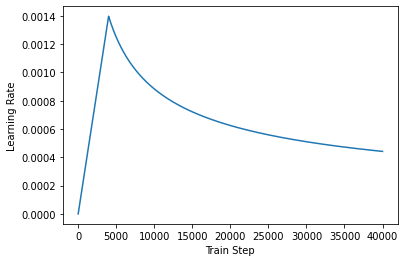

In [50]:
temp_learning_rate_schedule = CustomSchedule(dims)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step');

## Loss and metrics
Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [51]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [52]:
def loss_function(real, preds):
  mask = tf.math.not_equal(real, 0)
  loss = loss_obj(real, preds)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask
  return tf.reduce_sum(loss)/tf.reduce_sum(mask)  

In [53]:
def accuracy_function(real, preds):
  mask = tf.math.not_equal(real, 0)
  acc = tf.math.equal(real, tf.argmax(preds, axis=-1))
  acc = tf.math.logical_and(acc, mask)
  acc = tf.cast(acc, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(acc)/tf.reduce_sum(mask)

In [54]:
train_loss = tf.keras.metrics.Mean(name='training loss')
train_accuracy = tf.keras.metrics.Mean(name='training accuracy')

## Training and checkpointing

In [55]:
transformer = Transformer(input_vocab_size=pt_vocab_size,
                          output_vocab_size=en_vocab_size,
                          dims=dims,
                          dense_units=dense_units,
                          num_heads=num_heads,
                          num_layers=num_layers,
                          dropout_rate=0.1,
                          positions=MAX_TOKENS)

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every n epochs.

In [56]:
checkpoint_path = './checkpoint/train'

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exist, restore the latest checkpoint
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [57]:
EPOCHS = 20

In [58]:
sig=[tf.TensorSpec(shape=(None, None), dtype=tf.int64), tf.TensorSpec(shape=(None, None), dtype=tf.int64) ]

@tf.function(input_signature=sig)
def train_step(inputs, targets):
  targets_in = targets[:, :-1]
  targets_out = targets[:, 1:]
  
  with tf.GradientTape() as tape:
    preds, _ = transformer([inputs, targets_in], training=True)
    loss = loss_function(targets_out, preds)


  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables ))

  accuracy = accuracy_function(targets_out, preds)
  train_accuracy(accuracy)
  train_loss(loss)

In [59]:
import time

In [60]:
for epoch in range(EPOCHS):
  start_time = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (inp, targ)) in enumerate(train_batches):
    train_step(inp, targ)
    if batch%50==0:
      print(f'Epoch:{epoch} loss:{train_loss.result()} accuracy:{train_accuracy.result()}')
    
    

  if (epoch+1) % 5 ==0:
    ckpt_path = ckpt_manager.save()
    print(f"Checkpoint saved for {epoch} at {ckpt_path}")
  
  print(f'Epoch:{epoch} loss:{train_loss.result()} accuracy:{train_accuracy.result()}')
  print(f'Time taken {time.time()-start_time} sec')



Epoch:0 loss:8.878545761108398 accuracy:0.0008976660901680589
Epoch:0 loss:8.80595874786377 accuracy:0.0011531728086993098
Epoch:0 loss:8.696603775024414 accuracy:0.021979661658406258
Epoch:0 loss:8.577534675598145 accuracy:0.03288805112242699
Epoch:0 loss:8.432387351989746 accuracy:0.0428052581846714
Epoch:0 loss:8.258000373840332 accuracy:0.05324840545654297
Epoch:0 loss:8.065187454223633 accuracy:0.0627763420343399
Epoch:0 loss:7.866444110870361 accuracy:0.0711921751499176
Epoch:0 loss:7.677919387817383 accuracy:0.07851135730743408
Epoch:0 loss:7.507797718048096 accuracy:0.08572711050510406
Epoch:0 loss:7.3571319580078125 accuracy:0.09290416538715363
Epoch:0 loss:7.218499660491943 accuracy:0.10067281872034073
Epoch:0 loss:7.088996410369873 accuracy:0.1079525426030159
Epoch:0 loss:6.968545913696289 accuracy:0.11430076509714127
Epoch:0 loss:6.856551170349121 accuracy:0.12038902938365936
Epoch:0 loss:6.85271692276001 accuracy:0.12066695094108582
Time taken 86.28168177604675 sec
Epoch:1

## Making prediction

In [61]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

## START & END token

In [62]:
# we need to extract START and END tokens
print(tokenizer.pt.lookup(tokenizer.pt.tokenize([''])))
start_end = tokenizer.pt.tokenize([''])[0]
print('extract START and END tokens ',start_end)

start = start_end[0][tf.newaxis]
end = start_end[1][tf.newaxis]

print('Start',start)
print('End',end)

<tf.RaggedTensor [[b'[START]', b'[END]']]>
extract START and END tokens  tf.Tensor([2 3], shape=(2,), dtype=int64)
Start tf.Tensor([2], shape=(1,), dtype=int64)
End tf.Tensor([3], shape=(1,), dtype=int64)


## Prediction example

In [63]:
 # `tf.TensorArray` is required here (instead of a python list) so that the
 # dynamic-loop can be traced by `tf.function`

output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
output_array = output_array.write(0,start)
output_array.stack()

<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[2]])>

In [64]:
test_input = tf.constant(sentence)[tf.newaxis]
test_tokens = tokenizer.pt.tokenize(test_input)
print('input : ',test_tokens)
test_tokens = test_tokens.to_tensor() # convert ragged to tensor
print(test_tokens)

input :  <tf.RaggedTensor [[2, 125, 44, 85, 231, 84, 130, 84, 742, 16, 3]]>
tf.Tensor([[  2 125  44  85 231  84 130  84 742  16   3]], shape=(1, 11), dtype=int64)


In [65]:
# prediction example

for i in tf.range(MAX_TOKENS):
  # we need to transpose because output_array.stack() gives a tensor of shape [ i , 1] 
  # we need to convert [i, 1] to [1, i] a row with all the predicted tokens  [see next cell below]
  vector = tf.transpose(output_array.stack())
  predictions, _ = transformer([test_tokens, vector], training=False)
  # take the last sequence 
  prob = predictions[:,-1,:] # (batch_size, 1, vocab_size)
  # write it to the output
  next_tok = tf.argmax(prob, axis=-1)
  output_array = output_array.write(i+1, next_tok)

  if next_tok == end:
    break 

# work around for getting attention weights
vector = tf.transpose(output_array.stack())
_, attention_weights = transformer([test_tokens, vector[:,:-1]], training=False)


In [66]:
output_array.stack()

<tf.Tensor: shape=(12, 1), dtype=int64, numpy=
array([[  2],
       [ 81],
       [ 80],
       [ 37],
       [249],
       [ 75],
       [ 78],
       [ 89],
       [ 73],
       [855],
       [ 15],
       [  3]])>

In [67]:
tf.transpose(output_array.stack())

<tf.Tensor: shape=(1, 12), dtype=int64, numpy=array([[  2,  81,  80,  37, 249,  75,  78,  89,  73, 855,  15,   3]])>

In [68]:
final_predictions = tf.transpose(output_array.stack())
tokenizer.en.lookup(final_predictions)

<tf.Tensor: shape=(1, 12), dtype=string, numpy=
array([[b'[START]', b'this', b'is', b'a', b'problem', b'that', b'we',
        b'have', b'to', b'solve', b'.', b'[END]']], dtype=object)>

In [69]:
attention_weights.keys()

dict_keys(['attention_weights layer0', 'cross_attention_weights layer0', 'attention_weights layer1', 'cross_attention_weights layer1', 'attention_weights layer2', 'cross_attention_weights layer2', 'attention_weights layer3', 'cross_attention_weights layer3'])

In [70]:
print('shape of input tokens',test_tokens.shape)
print('shape of output prediction tokens',final_predictions.shape)

# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
print('shape of attention weights',attention_weights['cross_attention_weights layer3'].shape)

shape of input tokens (1, 11)
shape of output prediction tokens (1, 12)
shape of attention weights (1, 8, 11, 11)


In [71]:
k = [word.decode('utf-8') for word in tokenizer.en.lookup(final_predictions)[0].numpy()]
q = [word.decode('utf-8') for word in tokenizer.pt.lookup(test_tokens)[0].numpy()]

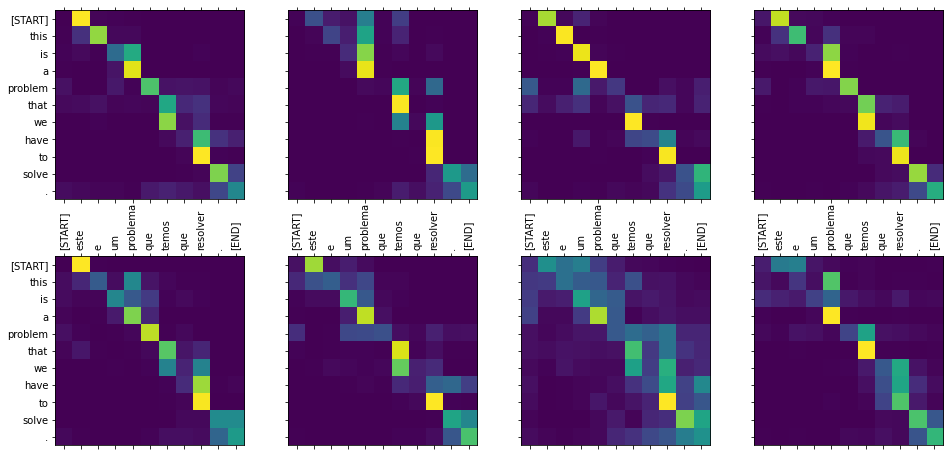

In [72]:
# lets create a plot to understand this better
attention_heads = attention_weights['cross_attention_weights layer3'][0]
fig,axs=plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey=True, sharex=True)
axs = axs.ravel()
for i, head in enumerate(attention_heads):
  axs[i].matshow(head)
  axs[i].set_xticks(range(head.shape[0]))
  axs[i].set_xticklabels(q, rotation=90)
  axs[i].set_yticks(range(head.shape[1]))
  axs[i].set_yticklabels(k,)


plt.subplots_adjust(hspace=0.3)
plt.show()  

## Translate method

In [111]:
class Translate(tf.Module):
  def __init__(self, transformer, tokenizer):
    super(Translate, self).__init__()

    self.tokenizer = tokenizer
    self.transformer = transformer

    # we need start and end tokens
    start_end = tokenizer.pt.tokenize([''])[0]
    self.start = start_end[0][tf.newaxis]
    self.end = start_end[1][tf.newaxis]

     # `tf.TensorArray` is required here (instead of a python list) so that the
     # dynamic-loop can be traced by `tf.function`

    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    self.output_array = output_array.write(0, start)


  def __call__(self, portuguese, length=MAX_TOKENS):
    portuguese = tf.constant(portuguese)[tf.newaxis]
    portuguese_tokens = self.tokenizer.pt.tokenize(portuguese).to_tensor()

    for i in tf.range(length):
      predicted_english = tf.transpose(self.output_array.stack())
      predictions, _ = self.transformer([portuguese_tokens, predicted_english], training=False)

      # select the last token from the seq_len dimension
      prediction_for_last_token = predictions[:, -1, :] # (batch_size, 1, vocab_size)
      
      predicted_token = tf.argmax(prediction_for_last_token, axis=-1)

      self.output_array = self.output_array.write(i+1, predicted_token)

      if predicted_token == self.end:
        break
      
    
    english_tokens = tf.transpose(self.output_array.stack())

    english = self.tokenizer.en.detokenize(english_tokens)

    _, attention_weights = self.transformer([portuguese_tokens, english_tokens[:, :-1]], training=False)

    output_dict = {
        'portuguese_input':portuguese,
        'portuguese_tokens':portuguese_tokens,
        'portuguese_lookup':self.tokenizer.pt.lookup(portuguese_tokens),

        'english_output':english,
        'english_tokens':english_tokens,
        'english_lookup':self.tokenizer.en.lookup(english_tokens),

        'attention_weights':attention_weights 
    }
    return output_dict


## Test translation

In [100]:
def translation_util(sentence, to_print=True, to_return=False):
  translate = Translate(transformer, tokenizer)
  output = translate(sentence)
  if to_print:
    print('input portuguese : ',sentence)
    print('output english : ',output['english_output'].numpy()[0])
  if to_return:
    return output

### example 1

In [101]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translation_util(sentence)

input portuguese :  este é um problema que temos que resolver.
output english :  b'this is a problem that we have to solve .'


### example 2

In [103]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'
translation_util(sentence)

input portuguese :  os meus vizinhos ouviram sobre esta ideia.
output english :  b'my neighbors heard about this idea .'


### example 3

In [104]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."
translation_util(sentence)

input portuguese :  vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
output english :  b"so i ' ll really share with you a few stories that happened to happen ."


### example 4

In [112]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."
translation_util(sentence)

input portuguese :  este é o primeiro livro que eu fiz.
output english :  b'this is the first book i did .'


## Attention plots

In [151]:
def plot_attention_head(ax, head, k, q):
    ax.matshow(head)
    ax.set_xticks(range(head.shape[0]))
    ax.set_xticklabels(q, rotation=90)
    ax.set_yticks(range(head.shape[1]))
    ax.set_yticklabels(k,)
    return ax


def get_params(output):
  heads = output['attention_weights']['cross_attention_weights layer3'][0]
  k = [word.decode('utf-8') for word in output['english_lookup'].numpy()[0]]
  q = [word.decode('utf-8') for word in output['portuguese_lookup'].numpy()[0]]
  return heads, k, q

def plot_util(output, figsize=(16, 8), sharey=True, sharex=True,**kwargs):

  attention_heads, k, q = get_params(output)

  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  k = k[1:]

  fig,axs=plt.subplots(nrows=2, ncols=4, figsize=figsize, sharey=sharey, sharex=sharex)
  axs = axs.ravel()
  for i, head in enumerate(attention_heads):
    axs[i]=plot_attention_head(axs[i], head, k ,q)


  plt.subplots_adjust(**kwargs)
  plt.show()  

### plot 1

In [160]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'
output = translation_util(sentence, to_return=True)

input portuguese :  este é um problema que temos que resolver.
output english :  b'this is a problem that we have to solve .'


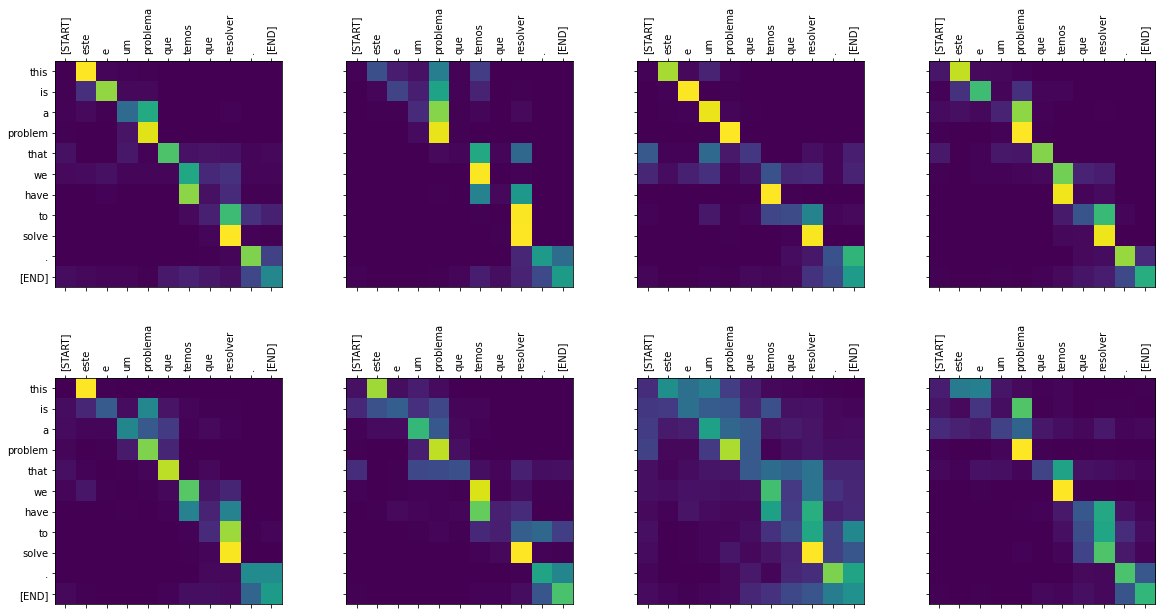

In [161]:
plot_util(output, figsize=(20,10), sharex=False, hspace=0.4)

### plot 2

In [157]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'
output = translation_util(sentence, to_return=True)

input portuguese :  os meus vizinhos ouviram sobre esta ideia.
output english :  b'my neighbors heard about this idea .'


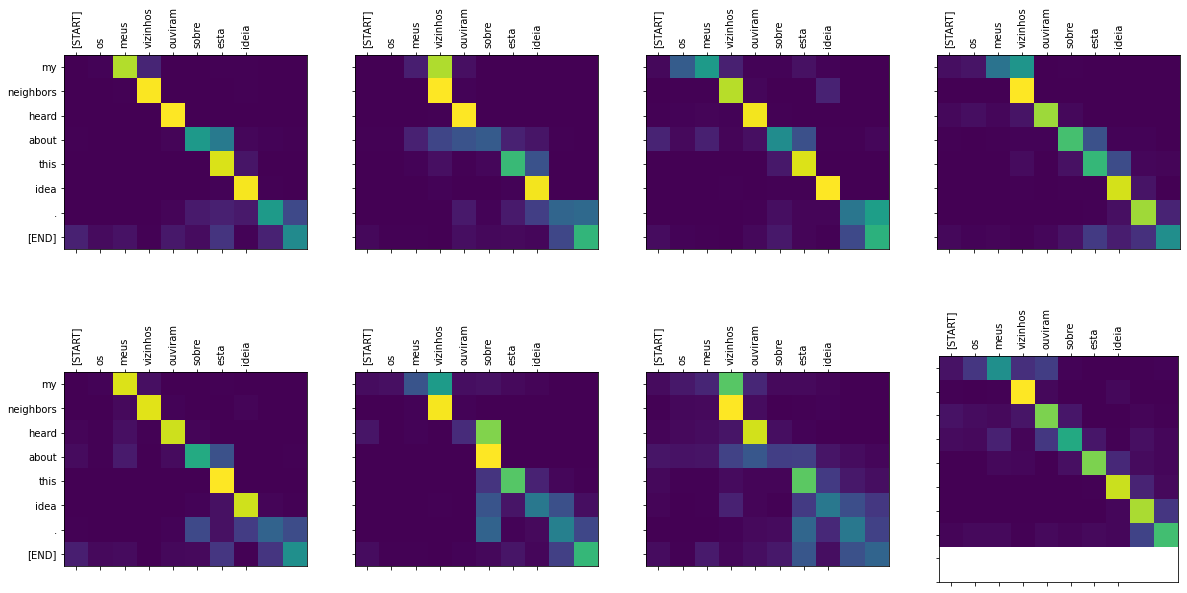

In [159]:
plot_util(output, figsize=(20,10), sharex=False, hspace=0.4)

### plot 3


In [153]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."
output = translation_util(sentence, to_return=True)

input portuguese :  vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
output english :  b"so i ' ll really share with you a few stories that happened to happen ."


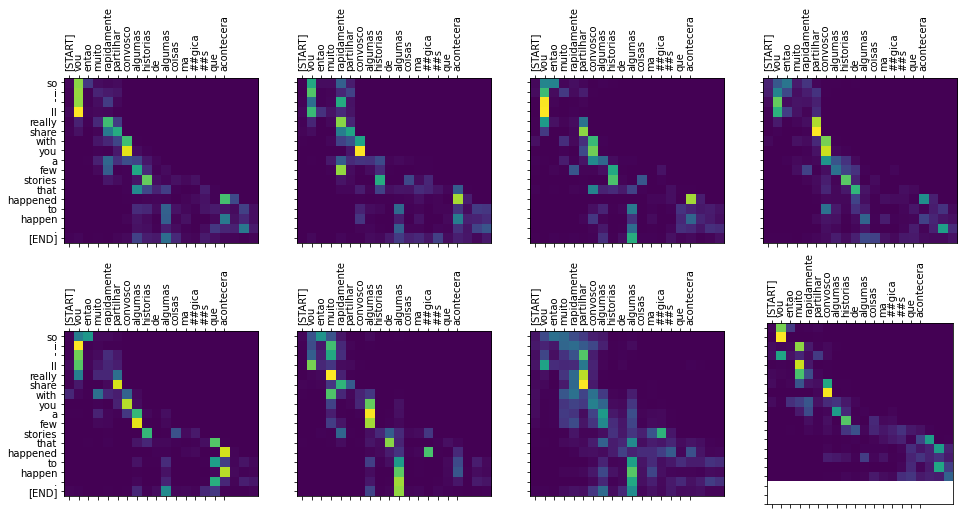

In [156]:
plot_util(output, figsize=(16,8), sharex=False, hspace=0.4)

### plot 4

In [137]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."
output = translation_util(sentence, to_return=True)

input portuguese :  este é o primeiro livro que eu fiz.
output english :  b'this is the first book i did .'


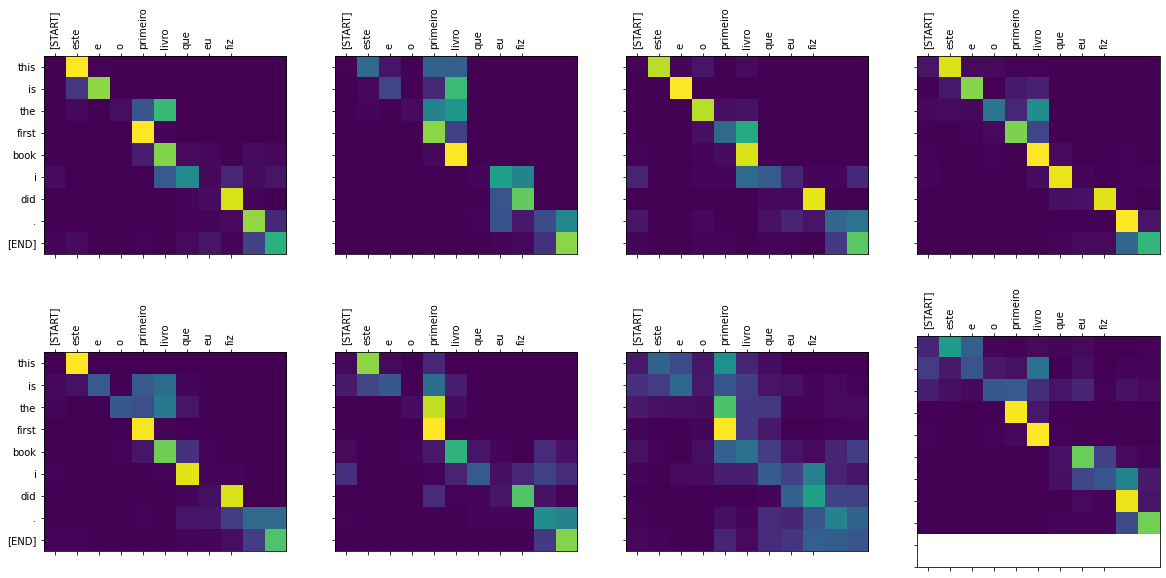

In [152]:
plot_util(output, figsize=(20,10), sharex=False)

### heat map 

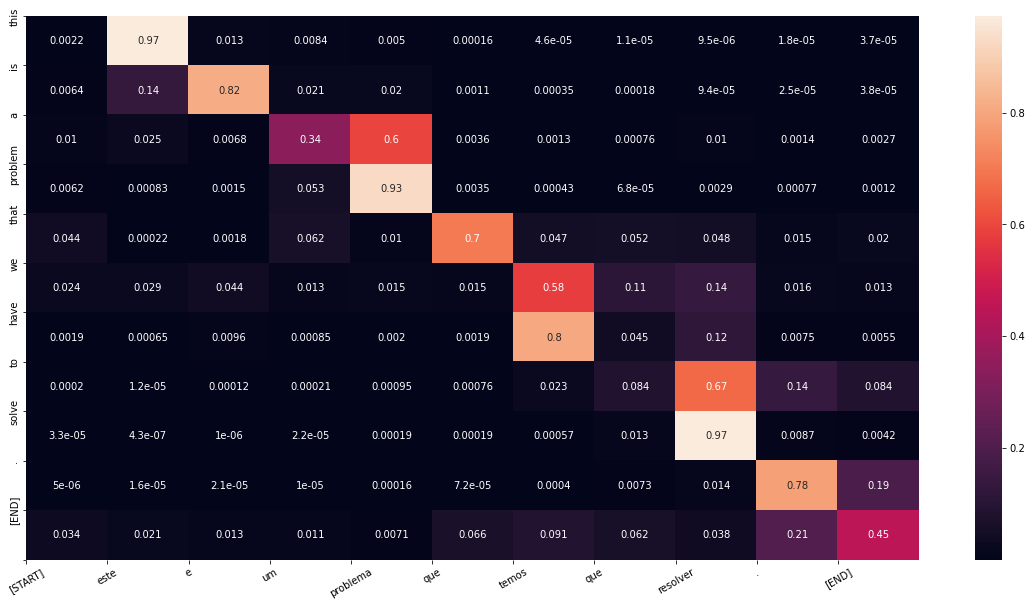

In [178]:
head, k, q = get_params(output)

plt.figure(figsize=(20,10))
sns.heatmap(head[0], annot=True);
plt.xticks(range(len(q)), q, rotation=30, ha="center")
plt.yticks(range(len(k)), k[1:], va="center")
plt.show()